Import the data

In [1]:
from braininvaders2015a.dataset import BrainInvaders2015a
import mne
from mne import create_info
from mne.io import RawArray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mne import Epochs, find_events
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
dataset = BrainInvaders2015a()
data_subject = dataset._get_single_subject_data(4)
print(data_subject)

{'session_1': {'run_1': <RawArray | 33 x 134272 (262.2 s), ~33.8 MB, data loaded>}, 'session_2': {'run_1': <RawArray | 33 x 141664 (276.7 s), ~35.7 MB, data loaded>}, 'session_3': {'run_1': <RawArray | 33 x 143584 (280.4 s), ~36.2 MB, data loaded>}}


In [3]:
data_ses1_run1 = data_subject['session_1']['run_1']
data_ses1_run1_pd = data_ses1_run1.to_data_frame()
data_ses1_run1_pd = data_ses1_run1_pd.drop(['time'],axis = 1)
print(data_ses1_run1_pd.groupby('STI 014').nunique()) #view the number of event that happened

            Fp1     Fp2     AFz      F7      F3     F4      F8     FC5    FC1  \
STI 014                                                                         
0.0      121931  124492  127465  125339  109724  90581  125581  127088  93984   
1.0         360     359     360     360     360    359     360     360    360   
2.0          72      72      72      72      72     72      72      72     72   

            FC2  ...      Pz      P4      P8     PO7      O1      Oz      O2  \
STI 014          ...                                                           
0.0      111524  ...  109056  118377  116271  130070  125348  114720  128224   
1.0         360  ...     359     360     360     360     360     360     360   
2.0          72  ...      72      72      72      72      72      72      72   

            PO8     PO9    PO10  
STI 014                          
0.0      128726  122141  105832  
1.0         360     360     359  
2.0          72      72      72  

[3 rows x 32 columns]


Preprocessing

In [4]:
def df_to_raw(df):
    sfreq = 512
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T
    df[:-1] *= 1e-6

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)
    raw.plot_psd()
    return raw

Creating RawArray with float64 data, n_channels=33, n_times=134272
    Range : 0 ... 134271 =      0.000 ...   262.248 secs
Ready.
Effective window size : 4.000 (s)


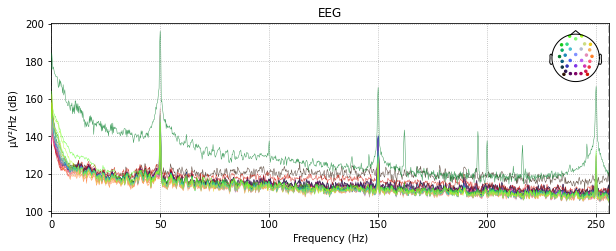

In [5]:
raw = df_to_raw(data_ses1_run1_pd) #convert back to raw

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Effective window size : 4.000 (s)


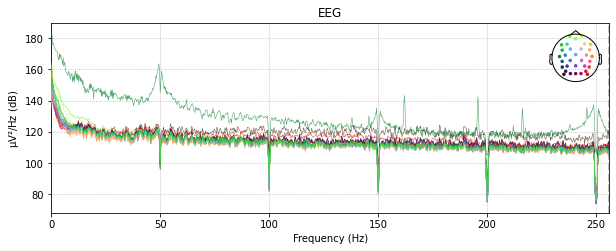

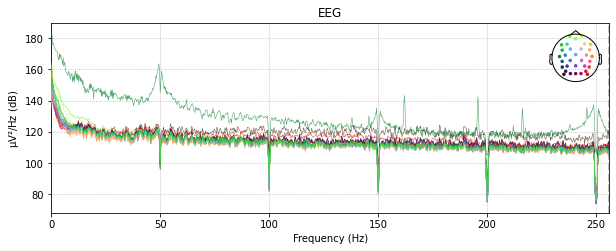

In [6]:
raw.notch_filter(np.arange(50, 251, 50)) #perform notch filter
raw.plot_psd()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 24.00 Hz: -6.02, -6.02 dB

Effective window size : 4.000 (s)


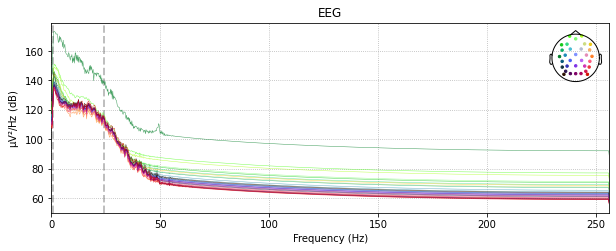

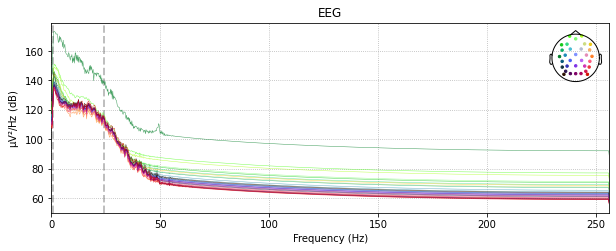

In [7]:
raw.filter(1,24,method = 'iir') #perform bandpass filter
raw.plot_psd()

In [8]:
##Extract the event by epoching
events = find_events(raw)
event_id = {'NonTarget': 1, 'Target': 2}
eeg_channels = mne.pick_types(raw.info, eeg=True)
epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=0.0, tmax=0.7, baseline=None, preload=True,verbose=False, picks=eeg_channels)
X = epochs.get_data()
y = epochs.events[:, -1]
print(X.shape)
print(y.shape)

432 events found
Event IDs: [1 2]
(432, 32, 359)
(432,)


In [9]:
from mne.preprocessing import Xdawn
from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
# perform XDAWN
signal_cov = compute_raw_covariance(raw, picks=eeg_channels)
xd = Xdawn(signal_cov=signal_cov)
epochs_dawn = xd.fit_transform(epochs)
print(epochs_dawn.shape)
# this epochs_dawn has the same shape as X. i found out that using epochs from Xdawn has higher acc than X from epoch.get_data()
X = epochs_dawn.reshape(epochs_dawn.shape[0],-1)

Using up to 1311 segments
Number of samples used : 133722
[done]
Computing rank from data with rank='full'
    EEG: rank 32 from info
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 32 from info
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
(432, 4, 359)


In [10]:
#perform PCA
#scaling
sc = StandardScaler()
X = sc.fit_transform(X)
# Perform PCA
pca = PCA()
# Determine transformed features
X_pca = pca.fit_transform(X)

In [11]:
#perform Gridsearch
X_train, X_test, y_train, y_test = train_test_split(X_pca,
                    y, test_size=0.3, random_state=1)
kernel = ['poly', 'rbf','linear']
C_range = [1, 2, 3,4]
param_grid = dict(C=C_range, kernel=kernel)
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("=========Best parameters=======")
print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

=========Best parameters=======
The best parameters are {'C': 3, 'kernel': 'rbf'} witha score of 0.96


In [12]:
clf = SVC(kernel='rbf',C=3)
clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
acc = np.sum(yhat == y_test)/len(y_test)
print(acc)

0.9769230769230769


Testing with all subject

In [13]:
def load_data(i):
    data_subject = dataset._get_single_subject_data(i)
    data_ses1_run1 = data_subject['session_1']['run_1']
    data_ses1_run1_pd = data_ses1_run1.to_data_frame()
    data_ses1_run1_pd = data_ses1_run1_pd.drop(['time'],axis = 1)
    return data_ses1_run1_pd

def df_to_raw(df):
    sfreq = 512
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T
    df[:-1] *= 1e-6

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)
    # raw.plot_psd()
    return raw

def filter(raw):
    raw.notch_filter(np.arange(50, 251, 50))
    raw.filter(1,24,method = 'iir')
    return raw

def do_pca(X):
    #scaling
    sc = StandardScaler()
    X = sc.fit_transform(X)
    # Perform PCA
    pca = PCA()
    # Determine transformed features
    X_pca = pca.fit_transform(X)
    return X_pca

In [14]:
def preprocess(i):
    data_subject1 = load_data(i)
    raw = df_to_raw(data_subject1)
    raw = filter(raw)
    events = find_events(raw)
    event_id = {'NonTarget': 1, 'Target': 2}
    eeg_channels = mne.pick_types(raw.info, eeg=True)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                        tmin=0.0, tmax=0.7, baseline=None, preload=True,verbose=False, picks=eeg_channels)
    X = epochs.get_data()
    X = X.reshape(X.shape[0],-1)
    y = epochs.events[:, -1]
    # XDAWN
    signal_cov = compute_raw_covariance(raw, picks=eeg_channels)
    xd = Xdawn(signal_cov=signal_cov) #for the n_components, i decided to use default value
    epochs_dawn = xd.fit_transform(epochs)
    # this epochs has the same shape as X. i found out that using epochs from Xdawn has higher acc than X from epoch.get_data()
    epochs = epochs_dawn.reshape(epochs_dawn.shape[0],-1)
    return epochs,y

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
accuracy = []
for i in range(1,44):
    clear_output(wait=True)
    if i == 1 or i == 27: # there are problem with data of subject 1 and 27 so i didn't use them
        continue
    print("subject number: ",i)
    X,y = preprocess(i)
    X_train_pca = do_pca(X)
    #split
    X_train, X_test, y_train, y_test = train_test_split(X_train_pca,
                    y, test_size=0.3, random_state=1)
                    
    #model
    clf = SVC(kernel='rbf',C=3)
    clf.fit(X_train,y_train)
    yhat = clf.predict(X_test)
    acc = np.sum(yhat == y_test)/len(y_test)
    accuracy.append(acc)

subject number:  43
Creating RawArray with float64 data, n_channels=33, n_times=129472
    Range : 0 ... 129471 =      0.000 ...   252.873 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 24.00 Hz: -6.02, -6.02 dB

360 events found
Event IDs: [1 2]
Using up to 1264 segments
Number of samples used : 128928
[done]
Computing rank from data with rank='full'
    EEG: rank 32 fr

In [ ]:
#rbf kernel, c=3 , xdawn
sum = 0
for i in range(len(accuracy)):
    print(f"subject{i+1}: ",accuracy[i])
    sum = sum + accuracy[i]
    avg = sum/len(accuracy)
print("Average :", avg)

subject1:  0.8794326241134752
subject2:  0.9351851851851852
subject3:  0.9769230769230769
subject4:  0.9615384615384616
subject5:  0.9320987654320988
subject6:  0.9351851851851852
subject7:  0.8692307692307693
subject8:  0.8950617283950617
subject9:  0.9387755102040817
subject10:  0.9327731092436975
subject11:  0.8362989323843416
subject12:  0.9012345679012346
subject13:  0.8901734104046243
subject14:  0.8981481481481481
subject15:  0.8907563025210085
subject16:  0.9021739130434783
subject17:  0.8769230769230769
subject18:  0.8888888888888888
subject19:  0.8846153846153846
subject20:  0.9351851851851852
subject21:  0.9210526315789473
subject22:  0.9013157894736842
subject23:  0.957983193277311
subject24:  0.930635838150289
subject25:  0.9074074074074074
subject26:  0.9174757281553398
subject27:  0.930635838150289
subject28:  0.9591836734693877
subject29:  0.8666666666666667
subject30:  0.9259259259259259
subject31:  0.9074074074074074
subject32:  0.9148936170212766
subject33:  0.866438